In [229]:
!pip install ta --quiet

DEPRECATION: Loading egg at /Users/andysstuff/anaconda3/lib/python3.12/site-packages/sympy-1.13.3-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [230]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import numpy as np
import requests

# Time range: past year
end_date = datetime.now()
start_date = end_date - timedelta(days=1095)

# Download data and include adjusted close
amzn_data = yf.download("AMZN", start=start_date, end=end_date, auto_adjust=False)

# Check available columns
# print("Columns:", amzn_data.columns)

   
# Get PE ratio from metadata
amzn = yf.Ticker("AMZN")
pe_ratio = amzn.info.get('trailingPE', None)

# If PE ratio is not available, set it to NaN
if pe_ratio is None:
    pe_ratio = float('nan')  # Set it to NaN for proper DataFrame handling
else:
    pe_ratio = float(pe_ratio)  # Ensure it's a float

# Create a Series for the PE ratio with the same date index as amzn_data
pe_series = pd.Series(pe_ratio, index=amzn_data.index)

# Combine the PE ratio Series with the historical data
amzn_data['PE_Ratio'] = pe_series

# Daily Volatility (using 7-day rolling standard deviation of log returns)
amzn_data['Log_Return'] = (amzn_data['Adj Close'] / amzn_data['Adj Close'].shift(1)).apply(np.log)
amzn_data['Volatility_7d'] = amzn_data['Log_Return'].rolling(window=7).std()

# Simulated sentiment based on daily percent change
if 'Adj Close' in amzn_data.columns:
    #MA past week
    amzn_data['MA_7'] = amzn_data['Adj Close'].rolling(window=7).mean() 
    #MA past month
    amzn_data['MA_30'] = amzn_data['Adj Close'].rolling(window=30).mean()
    #MA past year
    amzn_data['MA_365'] = amzn_data['Adj Close'].rolling(window=365).mean()

    amzn_data['Pct_Change'] = amzn_data['Adj Close'].pct_change()
    # amzn_data['Sentiment'] = amzn_data['Pct_Change'].apply(
    #     lambda x: 'Bullish' if x > 0 else ('Bearish' if x < 0 else 'Neutral')
    # )
else:
    print("⚠️ 'Adj Close' not found in the data. Cannot compute moving averages or sentiment.")

# # Replace with your Finnhub API key
# api_key = "d07ap6hr01qrslhn6ssgd07ap6hr01qrslhn6st0"
# # Ticker symbol for Amazon
# ticker = "AMZN"

# # Finnhub API endpoint for sentiment analysis
# url = f"https://finnhub.io/api/v1/news-sentiment?symbol={ticker}&token={api_key}"

# # Make the API request
# response = requests.get(url)

# sentiment_data = None
# # Check if the request was successful
# if response.status_code == 200:
#     sentiment_data = response.json()
#     print("Sentiment Data:", sentiment_data)
#     sentiment_score = sentiment_data["sentiment"]
#     amzn_data['Sentiment_score'] = sentiment_score
# else:
#     print("Failed to fetch sentiment data. Status code:", response.status_code)
#     amzn_data['Sentiment_score'] = float('nan')  # Set sentiment score to NaN if API fails


# Check available columns after adding metrics
# Now, modify the second index
new_columns = []

for col in amzn_data.columns:
    # Create a new tuple with the existing first index and 'AMZN' as the second index
    new_columns.append((col[0], 'AMZN'))

# Update the DataFrame's columns
amzn_data.columns = pd.MultiIndex.from_tuples(new_columns)

print("Columns:", amzn_data.columns)

# Display last few rows
print(amzn_data.head())
print(amzn_data.tail())

[*********************100%***********************]  1 of 1 completed

Columns: MultiIndex([(    'Adj Close', 'AMZN'),
            (        'Close', 'AMZN'),
            (         'High', 'AMZN'),
            (          'Low', 'AMZN'),
            (         'Open', 'AMZN'),
            (       'Volume', 'AMZN'),
            (     'PE_Ratio', 'AMZN'),
            (   'Log_Return', 'AMZN'),
            ('Volatility_7d', 'AMZN'),
            (         'MA_7', 'AMZN'),
            (        'MA_30', 'AMZN'),
            (       'MA_365', 'AMZN'),
            (   'Pct_Change', 'AMZN')],
           )
             Adj Close       Close        High         Low        Open  \
                  AMZN        AMZN        AMZN        AMZN        AMZN   
Date                                                                     
2022-04-29  124.281502  124.281502  130.761002  121.625000  129.848999   
2022-05-02  124.500000  124.500000  124.667999  118.375000  122.401001   
2022-05-03  124.253502  124.253502  126.220497  122.824997  124.053497   
2022-05-04  125.928497  12

In [231]:
amzn_data.describe()

,Adj Close,Close,High,Low,Open,Volume,PE_Ratio,Log_Return,Volatility_7d,MA_7,MA_30,MA_365,Pct_Change
,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN
count,751.000000,751.000000,751.000000,751.000000,751.000000,7.510000e+02,7.510000e+02,750.000000,744.000000,745.000000,722.000000,387.000000,750.000000
mean,149.790147,149.790147,151.672922,147.739130,149.750484,5.554261e+07,3.388087e+01,0.000550,0.020794,149.757131,149.832801,145.478870,0.000817
std,40.885087,40.885087,41.083078,40.597538,40.901644,2.692518e+07,1.350931e-13,0.023124,0.010101,40.806653,40.542510,23.369806,0.023174
min,81.820000,81.820000,83.480003,81.430000,82.800003,1.500750e+07,3.388087e+01,-0.094081,0.004918,83.874286,88.232667,114.261919,-0.089791
25%,115.005001,115.005001,116.915001,113.139999,114.750000,3.867215e+07,3.388087e+01,-0.012157,0.013903,114.928571,114.104251,122.014178,-0.012084
50%,142.220001,142.220001,143.380005,139.910004,141.320007,4.910070e+07,3.388087e+01,0.000418,0.018606,141.070003,136.843001,144.154274,0.000418
75%,183.790001,183.790001,185.879997,181.919998,183.830002,6.497670e+07,3.388087e+01,0.014042,0.024463,183.532859,183.392251,165.550603,0.014141
max,242.059998,242.059998,242.520004,238.029999,239.020004,2.726620e+08,3.388087e+01,0.114915,0.067685,237.695714,230.223333,186.330247,0.121778


In [232]:
amzn_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 751 entries, 2022-04-29 to 2025-04-28
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   (Adj Close, AMZN)      751 non-null    float64
 1   (Close, AMZN)          751 non-null    float64
 2   (High, AMZN)           751 non-null    float64
 3   (Low, AMZN)            751 non-null    float64
 4   (Open, AMZN)           751 non-null    float64
 5   (Volume, AMZN)         751 non-null    int64  
 6   (PE_Ratio, AMZN)       751 non-null    float64
 7   (Log_Return, AMZN)     750 non-null    float64
 8   (Volatility_7d, AMZN)  744 non-null    float64
 9   (MA_7, AMZN)           745 non-null    float64
 10  (MA_30, AMZN)          722 non-null    float64
 11  (MA_365, AMZN)         387 non-null    float64
 12  (Pct_Change, AMZN)     750 non-null    float64
dtypes: float64(12), int64(1)
memory usage: 82.1 KB


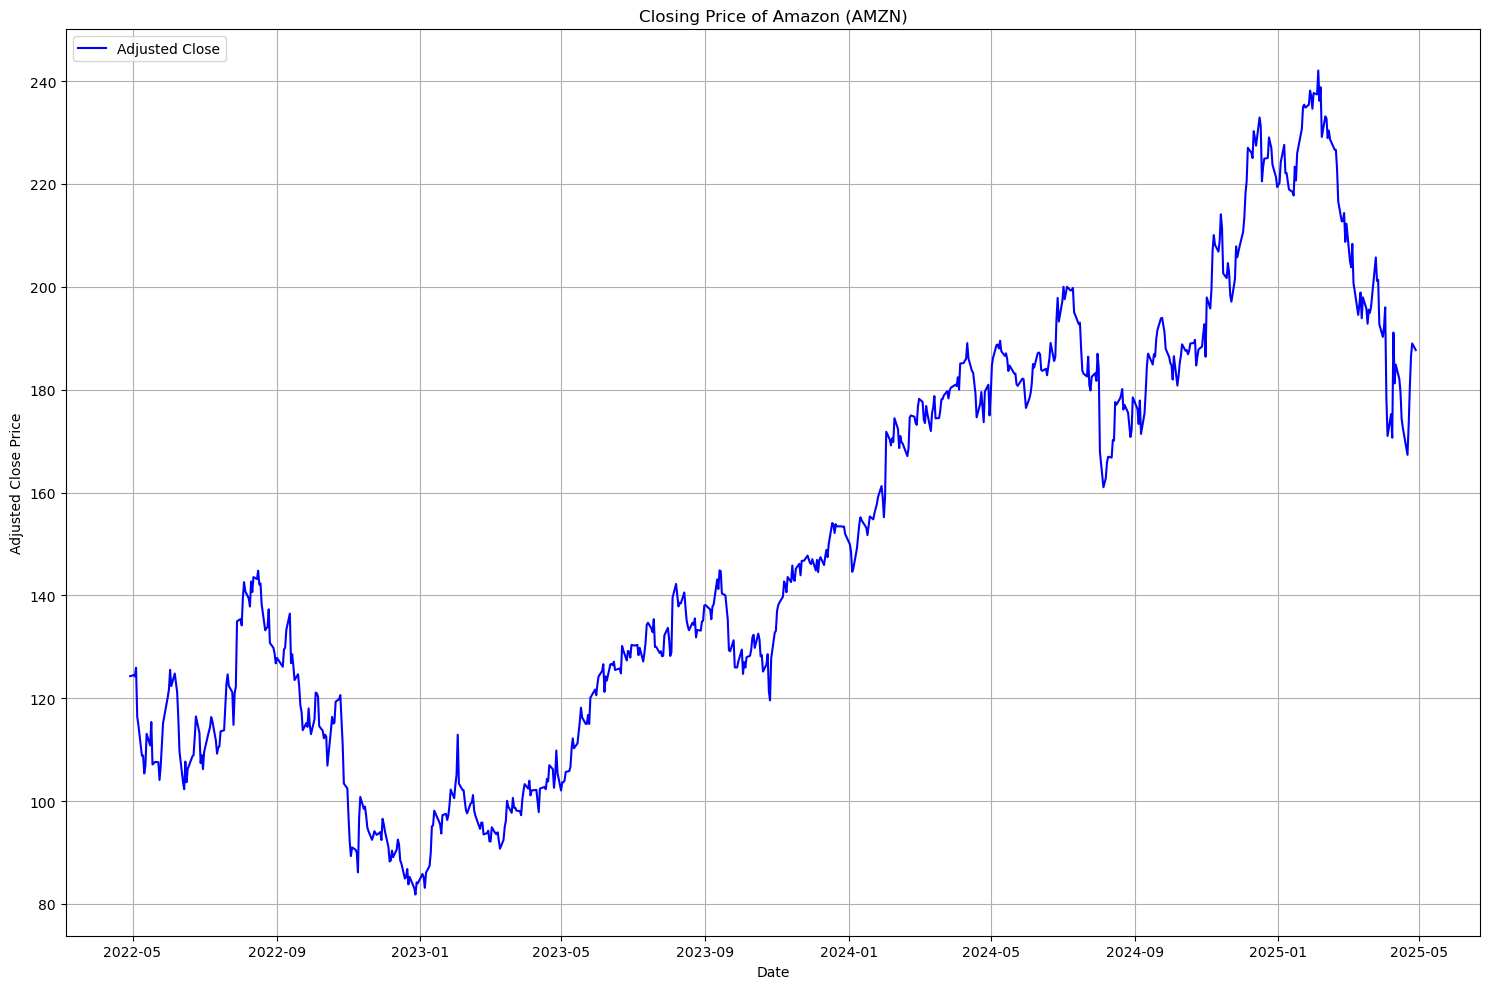

In [233]:

# Time range: past 3 years
# end_date = datetime.now()
# start_date = end_date - timedelta(days=1095)

# Download data for AMZN
# amzn_data = yf.download("AMZN", start=start_date, end=end_date, auto_adjust=False)

# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

# Plotting the adjusted closing price
plt.plot(amzn_data['Adj Close'], label='Adjusted Close', color='blue')
plt.ylabel('Adjusted Close Price')
plt.xlabel('Date')
plt.title("Closing Price of Amazon (AMZN)")
plt.legend(loc='upper left')
plt.grid()

plt.tight_layout() 
plt.show()


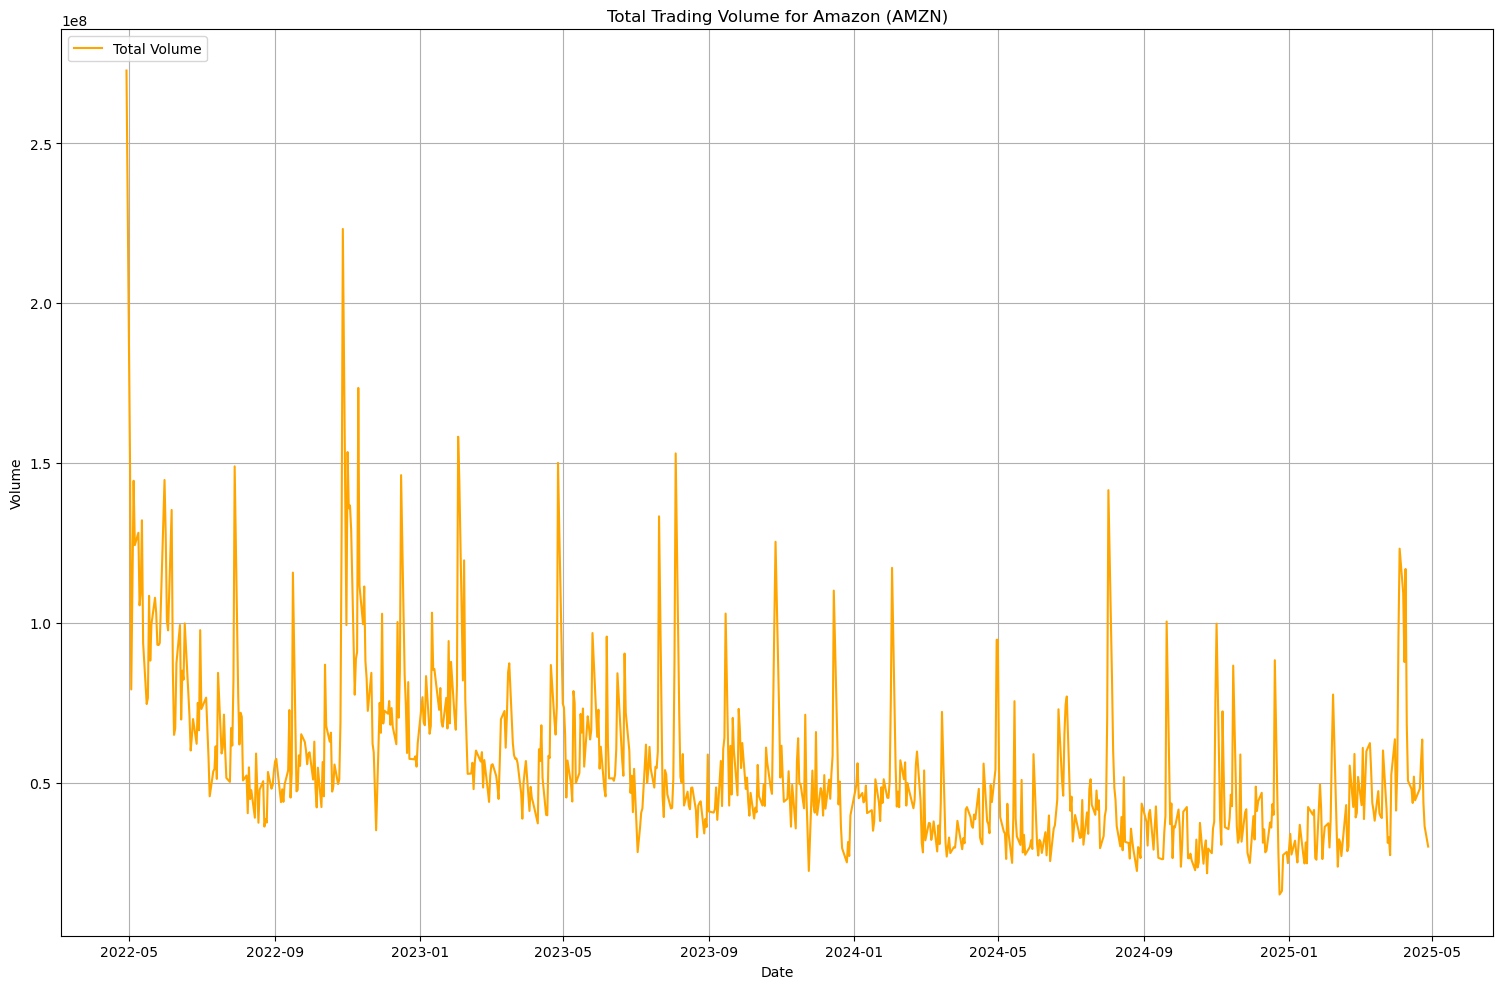

In [234]:
# Now let's plot the total volume of stock being traded each day for Amazon
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

# Plotting the trading volume for AMZN
plt.plot(amzn_data['Volume'], label='Total Volume', color='orange')
plt.ylabel('Volume')
plt.xlabel('Date')
plt.title("Total Trading Volume for Amazon (AMZN)")
plt.legend(loc='upper left')
plt.grid()

plt.tight_layout() 
plt.show()

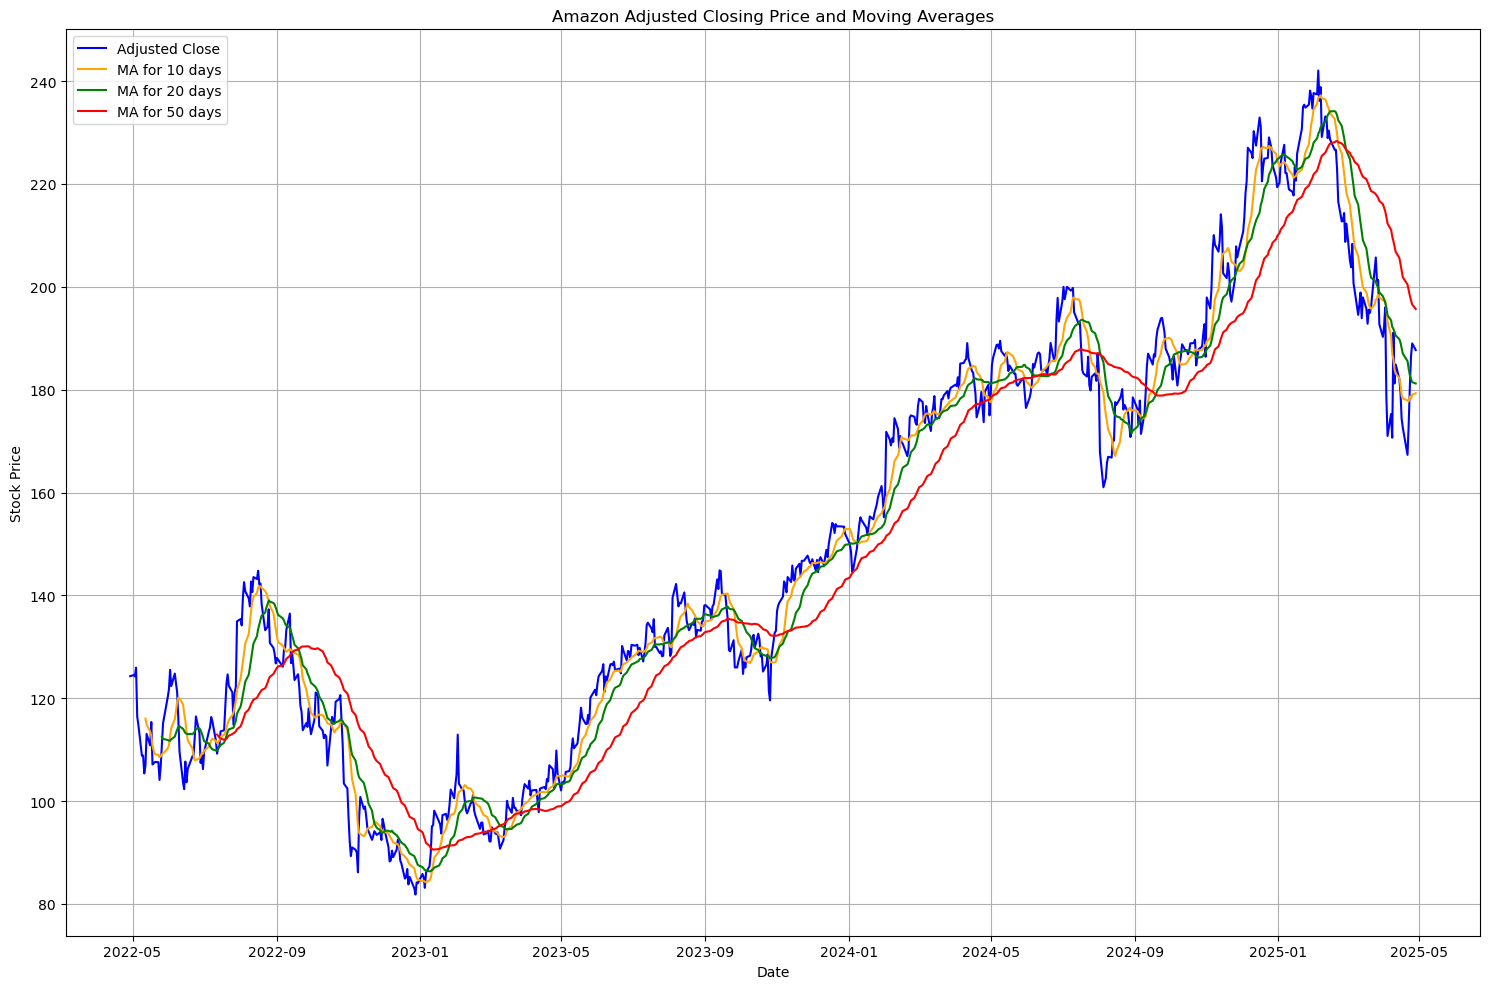

In [235]:
ma_day = [10, 20 ,50]
for ma in ma_day:
    amzn_data[f"MA for {ma} days"] = amzn_data['Adj Close'].rolling(ma).mean()

plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=0.2)

# Plotting adjusted close and moving averages
plt.plot(amzn_data['Adj Close'], label='Adjusted Close', color='blue')
plt.plot(amzn_data['MA for 10 days'], label='MA for 10 days', color='orange')
plt.plot(amzn_data['MA for 20 days'], label='MA for 20 days', color='green')
plt.plot(amzn_data['MA for 50 days'], label='MA for 50 days', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title("Amazon Adjusted Closing Price and Moving Averages")
plt.legend()
plt.tight_layout()
plt.grid()

# Show the plot
plt.show()


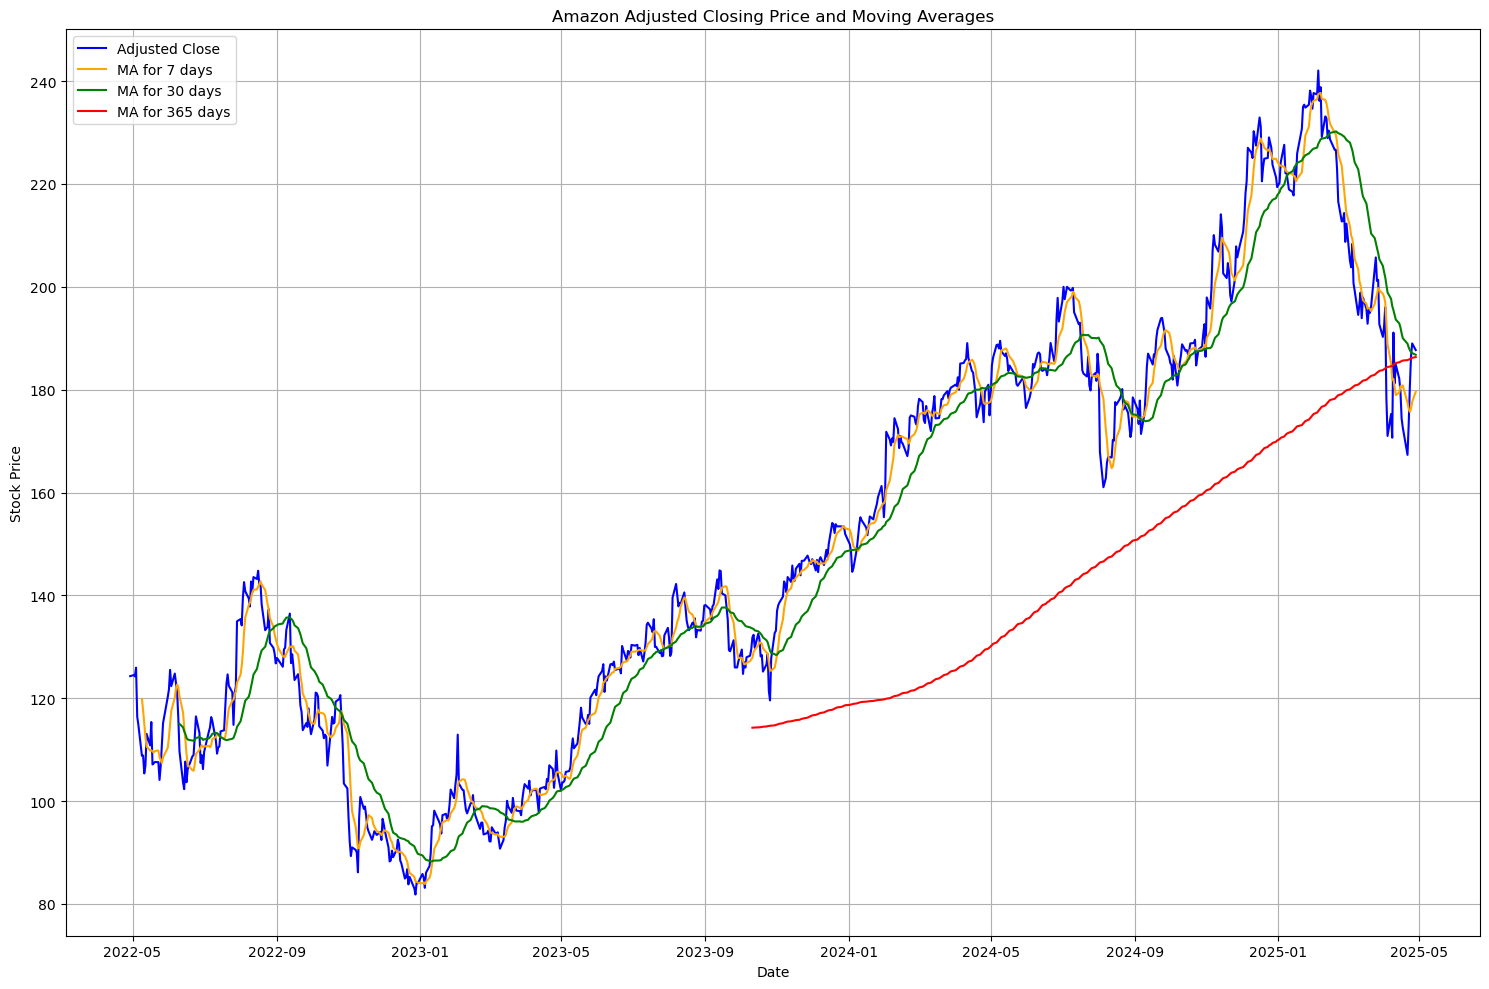

In [236]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=0.2)

# Plotting adjusted close and moving averages
plt.plot(amzn_data['Adj Close'], label='Adjusted Close', color='blue')
plt.plot(amzn_data['MA_7'], label='MA for 7 days', color='orange')
plt.plot(amzn_data['MA_30'], label='MA for 30 days', color='green')
plt.plot(amzn_data['MA_365'], label='MA for 365 days', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title("Amazon Adjusted Closing Price and Moving Averages")
plt.legend()
plt.tight_layout()
plt.grid()

# Show the plot
plt.show()


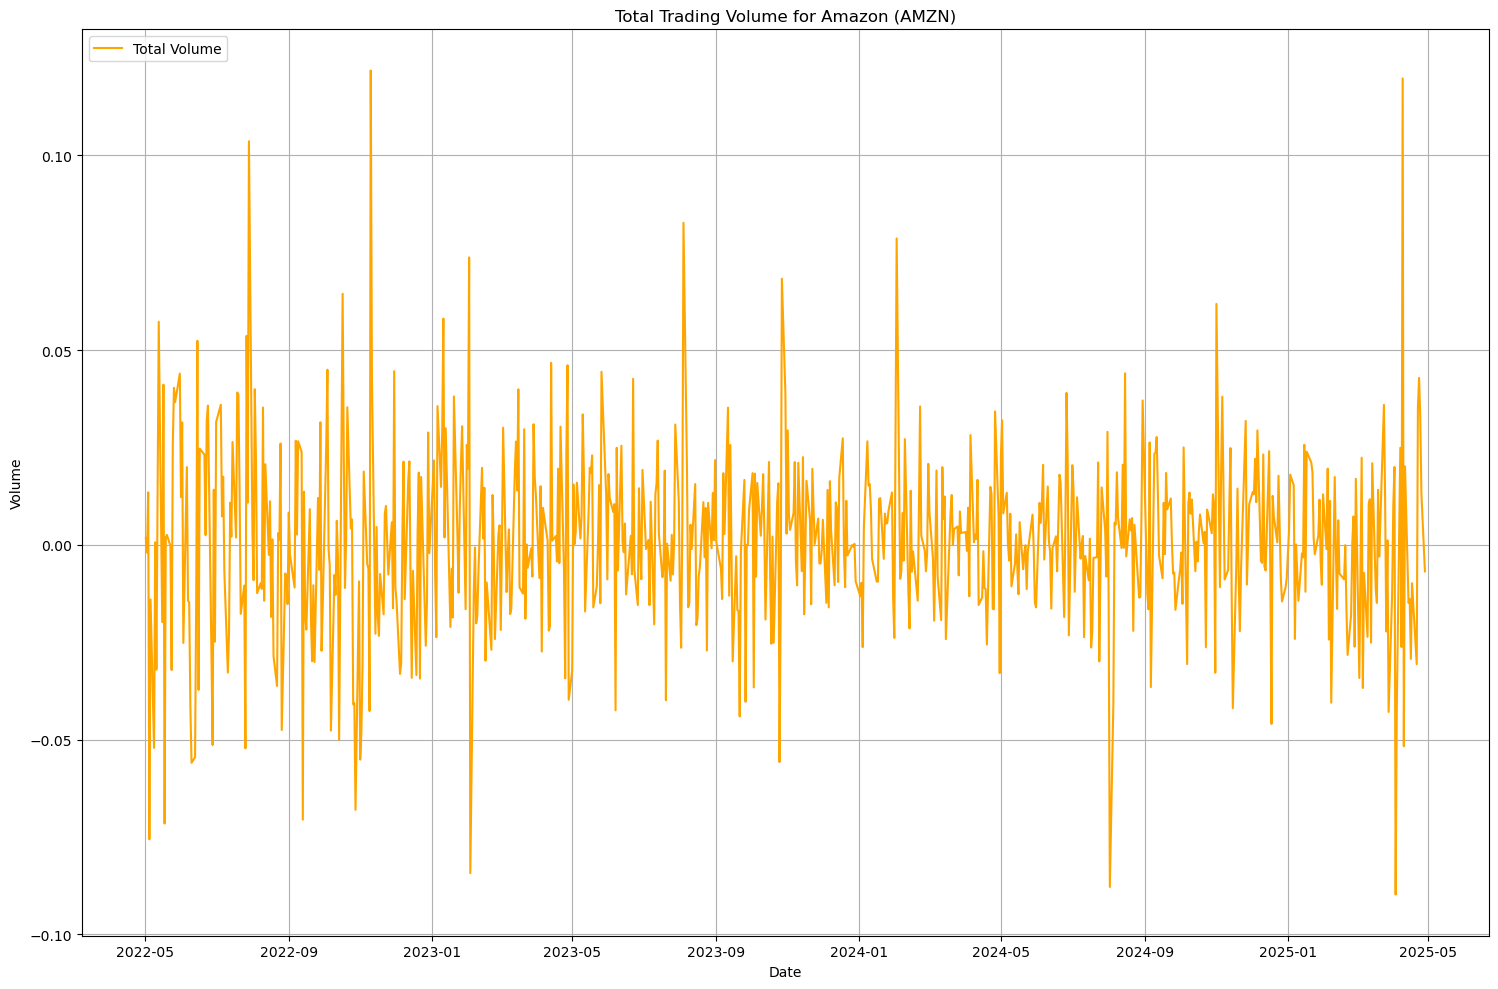

In [238]:
# Now let's plot the total volume of stock being traded each day for Amazon
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

# Plotting the trading volume for AMZN
plt.plot(amzn_data['Pct_Change'], label='Total Volume', color='orange')
plt.ylabel('Volume')
plt.xlabel('Date')
plt.title("Total Trading Volume for Amazon (AMZN)")
plt.legend(loc='upper left')
plt.grid()

plt.tight_layout() 
plt.show()

In [239]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# Drop NaN values resulting from calculations

# Drop NaN values resulting from calculations
amzn_data = amzn_data.dropna()

scaler = StandardScaler()
# Selecting features for training
features = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Log_Return', 'Pct_Change', 'MA_7', 'MA_30', 'MA_365', 'Volatility_7d', 'PE_Ratio']
data = amzn_data[features]

amzn_data[features] = scaler.fit_transform(amzn_data[features])

In [240]:
import joblib 

joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [241]:
X = []
y = []
# print(len(amzn_data))
time_steps = 30  # Lookback period
for i in range(time_steps, len(amzn_data)):
    X.append(amzn_data[features].iloc[i-time_steps:i].values)  # Use NumPy slicing instead of iloc
    y.append(amzn_data['Close'].iloc[i])

X, y = np.array(X), np.array(y)

# Train-test split for LSTM
# from sklearn.model_selection import train_test_split
# the 80% to 20% training-test split ensures that the predicted closing prices are not cheating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)

(285, 30, 13)


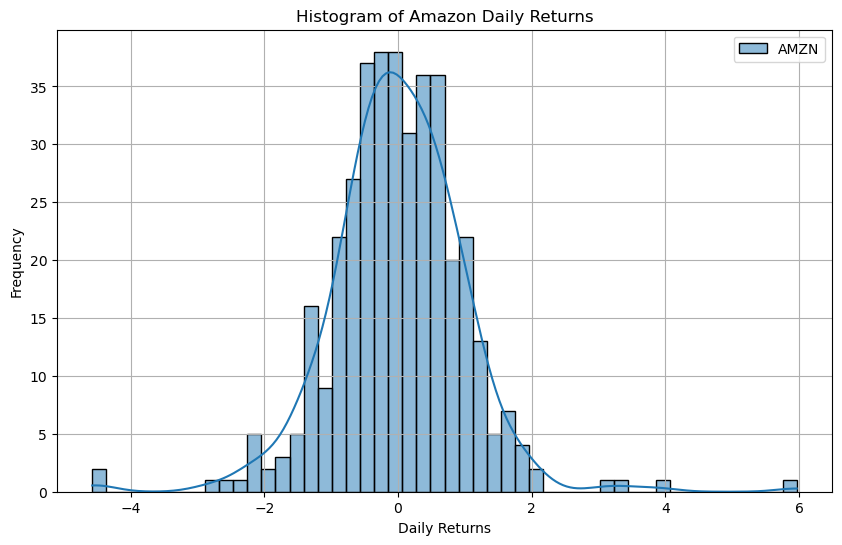

In [242]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(amzn_data['Pct_Change'].dropna(), bins=50, kde=True, color='seagreen')
plt.title('Histogram of Amazon Daily Returns')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.grid()
plt.show()
  

In [243]:
# # Check the data     
# print(amzn_data['Sentiment'].describe())
# print(amzn_data['Sentiment'].head())
# print(amzn_data['Sentiment'].tail())


# # Handle missing or invalid data
# amzn_data['Sentiment'].dropna(inplace=True)

# print(amzn_data['Sentiment'].isnull().sum())
# amzn_data['Sentiment'].dropna(inplace=True)
# # print(amzn_data['Sentiment'].dtype)

# # Ensure sufficient data
# if len(amzn_data['Sentiment']) < 2:
#     raise ValueError("Not enough data points in 'Sentiment' column for plotting.")


MultiIndex([(     'Adj Close', 'AMZN'),
            (         'Close', 'AMZN'),
            (          'High', 'AMZN'),
            (           'Low', 'AMZN'),
            (          'Open', 'AMZN'),
            (        'Volume', 'AMZN'),
            (      'PE_Ratio', 'AMZN'),
            (    'Log_Return', 'AMZN'),
            ( 'Volatility_7d', 'AMZN'),
            (          'MA_7', 'AMZN'),
            (         'MA_30', 'AMZN'),
            (        'MA_365', 'AMZN'),
            (    'Pct_Change', 'AMZN'),
            ('MA for 10 days',     ''),
            ('MA for 20 days',     ''),
            ('MA for 50 days',     '')],
           )
           Adj Close     Close      High       Low      Open    Volume  \
                AMZN      AMZN      AMZN      AMZN      AMZN      AMZN   
Date                                                                     
2023-10-11 -1.976660 -1.976660 -2.024425 -1.996514 -2.047077 -0.152478   
2023-10-12 -1.957440 -1.957440 -1.931957 -1.933555

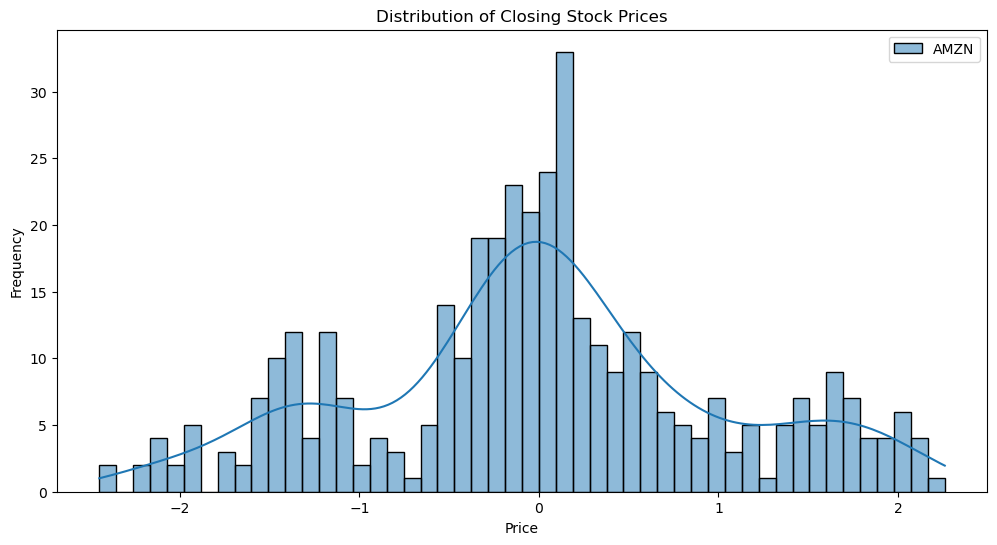

In [250]:
import seaborn as sns
import matplotlib.pyplot as plt
 

# Convert 'Close' column to numeric
# amzn_data['Close'] = pd.to_numeric(amzn_data['Close'], errors='coerce')
assert isinstance(amzn_data, pd.DataFrame)

print(amzn_data.columns)
# Drop rows with missing 'Close' values
# amzn_data = amzn_data.dropna(subset=['Close'])

print(amzn_data.head())
print(amzn_data.tail())
# Visualize the distribution of 'Close' prices
plt.figure(figsize=(12, 6))
sns.histplot(amzn_data['Close'], bins=50, kde=True, color='blue')
plt.title('Distribution of Closing Stock Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# # Visualize the 'Sentiment_Score'
# plt.figure(figsize=(12, 6))
# sns.histplot(amzn_data['Sentiment'], bins=50, kde=True, color='green')
# plt.title('Distribution of Sentiment Scores')
# plt.xlabel('Sentiment Score')
# plt.ylabel('Frequency')
# plt.show()


In [246]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Tuning the LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(50),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# model.fit(X_train, y_train, batch_size=1, epochs=1)
model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test))




Epoch 1/30


/Users/andysstuff/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.3636 - val_loss: 0.1191
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1845 - val_loss: 0.0897
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1113 - val_loss: 0.1024
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0967 - val_loss: 0.0429
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0850 - val_loss: 0.0344
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0695 - val_loss: 0.0446
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0583 - val_loss: 0.0288
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0544 - val_loss: 0.0305
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0404 - val_loss: 0.0396
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0466 - val_loss: 0.0280
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0443 - val_loss: 0.0313
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0445 - val_loss: 0.0290
Epoch 13/30


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


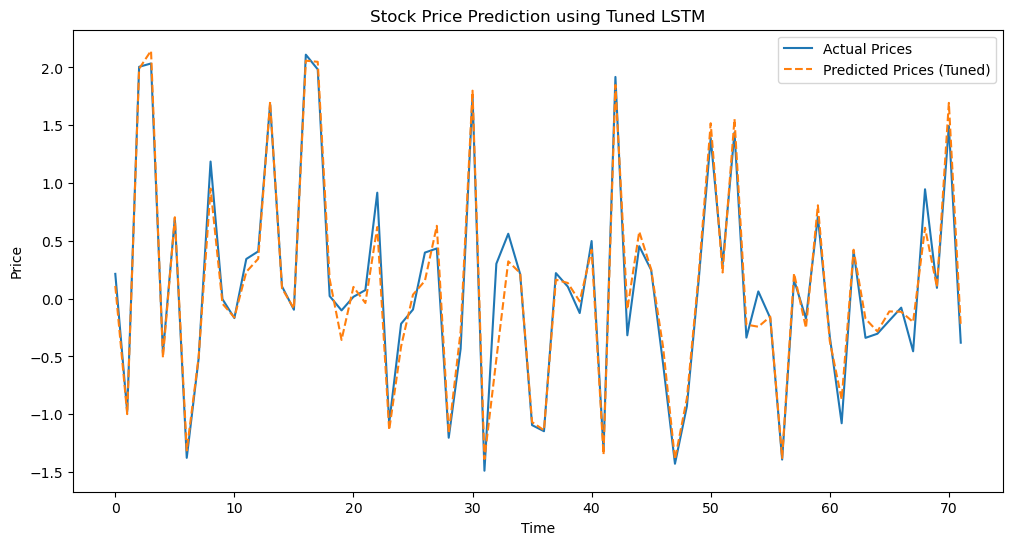

In [185]:
lstm_predictions_model = model.predict(X_test)

# Plot the results for the tuned LSTM model
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(lstm_predictions_model, label="Predicted Prices (Tuned)", linestyle='--')
plt.title('Stock Price Prediction using Tuned LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

